In [1]:
import pandas as pd
import numpy as np

import re
import string
# BERT-Embeddings
from keybert import KeyBERT
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
#import altair as alt
#alt.renderers.enable('mimetype')
from sklearn.metrics.pairwise import cosine_similarity

/home/haochenyang/personal/miniconda3/miniconda3/envs/control/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-04 11:08:30.113919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 11:08:30.835707: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Preprocessing Data

In [2]:
books_data = pd.read_csv("book1100k-1200k.csv", usecols=['Id', 'Name', 'Authors', 'ISBN', 'PublishYear', 'Publisher', 'Language', 'Description', 'Rating','pagesNumber'])
display(books_data.shape)
books_data.head(20)

(41892, 10)

,Id,Name,Authors,ISBN,Rating,PublishYear,Publisher,Language,pagesNumber,Description
0,1100003,The Prince,Niccolò Machiavelli,0226500438,3.82,1998,University of Chicago Press,NaN,151,"The most famous book on politics ever written,..."
1,1100004,"Sermons from Duke Chapel: Voices from ""A Great...",William H. Willimon,0822334836,4.29,2005,Duke University Press Books,NaN,384,Many of America’s greatest Protestant preacher...
2,1100007,The Last Sorcerer,Ethan Russo,0789012707,4.00,2001,Haworth Integrative Healing Press,NaN,368,NaN
3,1100009,The Idea of a University,John Henry Newman,0300064055,4.12,1996,Yale University Press,NaN,400,"Since its publication almost 150 years ago, <i..."
4,1100010,Caring and Curing: Health and Medicine in the ...,Ronald L. Numbers,0801857961,3.00,1997,Johns Hopkins University Press,NaN,622,"Most religious traditions have a rich, if larg..."
5,1100012,Inequality Reexamined [Electronic Resource],Amartya Sen,0198289286,4.11,2007,Russell Sage Foundation; Clarendon Press,NaN,222,NaN
6,1100013,The Alamo Remembered: Tejano Accounts and Pers...,Timothy Matovina,0292751850,3.77,1995,University of Texas Press,NaN,146,As Mexican soldiers fought the mostly Anglo-Am...
7,1100020,Rousseau: 'the Discourses' and Other Early Pol...,Jean-Jacques Rousseau,0521413818,4.05,1997,Cambridge University Press,NaN,437,The work of Jean-Jacques Rousseau is presented...
8,1100021,"How Not to Study Judaism, Examples and Counter...",Jacob Neusner,0761827838,1.00,2004,University Press of America,NaN,176,"In How Not to Study Judaism, Examples and Coun..."
9,1100025,Basic Research and Technologies for Two-Stage-...,Dieter Jacob,3527277358,5.00,2005,Wiley-Vch,NaN,683,Focusing on basic aspects of future reusable s...


In [7]:
print(list(books_data.Description[books_data.Id == 1100009]))#Description with url and html tag

['Since its publication almost 150 years ago, <i>The Idea of a University</i> has had an extraordinary influence on the shaping and goals of higher education. The issues that John Henry Newman raised—the place of religion and moral values in the university setting, the competing claims of liberal and professional education, the character of the academic community, the cultural role of literature, the relation of religion and science—have provoked discussion from Newman\'s time to our own. This edition of <i>The Idea of a University</i> includes the full text of "University Teaching" and four selections from "University Subjects," together with five essays by leading scholars that explore the background and the present day relevance of Newman\'s themes.<br /><br />In the essays Martha Garland discusses the character and organization of the early nineteenth-century English universities upon which Newman based much of his vision; Frank M. Turner traces the impact of Newman\'s influence du

# Feature Selection
1. ISBN is not useable
2. Language have too many NaN

In [3]:
books_data = books_data.loc[:, ['Id', 'Name', 'Authors', 'PublishYear', 'Publisher', 'Description', 'Rating','pagesNumber']]
books_data

,Id,Name,Authors,PublishYear,Publisher,Description,Rating,pagesNumber
0,1100003,The Prince,Niccolò Machiavelli,1998,University of Chicago Press,"The most famous book on politics ever written,...",3.82,151
1,1100004,"Sermons from Duke Chapel: Voices from ""A Great...",William H. Willimon,2005,Duke University Press Books,Many of America’s greatest Protestant preacher...,4.29,384
2,1100007,The Last Sorcerer,Ethan Russo,2001,Haworth Integrative Healing Press,NaN,4.00,368
3,1100009,The Idea of a University,John Henry Newman,1996,Yale University Press,"Since its publication almost 150 years ago, <i...",4.12,400
4,1100010,Caring and Curing: Health and Medicine in the ...,Ronald L. Numbers,1997,Johns Hopkins University Press,"Most religious traditions have a rich, if larg...",3.00,622
...,...,...,...,...,...,...,...,...
41887,1199988,Family: Everyday Stories About the Miracle of ...,Mary Pesaresi,1996,Prima Lifestyles,Family is a beautiful gift collection of 60 re...,5.00,288
41888,1199990,Snail Eggs & Samphire: Dispatches from the Foo...,Derek Cooper,2001,Pan Books,Derek Cooper's career in journalism has focuse...,4.17,422
41889,1199992,Snail Eggs And Samphire: Dispatches From The F...,Derek Cooper,2000,MacMillan,Derek Cooper's career in journalism has focuse...,4.17,422
41890,1199993,The Confession (The Yalta Boulevard Sequence #2),Olen Steinhauer,2005,Minotaur Books,"Eastern Europe, 1956: Comrade Inspector Ferenc...",3.87,336


In [ ]:
## Remove URLs and HTML Tags and Punctuations from the Description.
# **Description** feature contains URLs, HTML tags and punctuations.
# - Before changing the letter case, assign missing **Publisher** some temporary string `unknown` to retain these missing values during string transformation. 
books_data.dropna(subset=["Description"], inplace=True)
url_pattern = re.compile(r'https?://\S+|www\.\S+')
def remove_url(text):   
    return re.sub(url_pattern, r'', text)

html_pattern = re.compile('<[^>]*>')
def clean_html_tags(text):
    return re.sub(html_pattern, r'', text)

punctuations = string.punctuation
def remove_punctuations(text):
    return text.translate(str.maketrans('', '', punctuations))

books_data.Description = books_data.Description.apply(remove_url)
books_data.Description = books_data.Description.apply(clean_html_tags)
books_data.Description = books_data.Description.apply(remove_punctuations)
books_data[["Publisher"]] = books_data[["Publisher"]].fillna("unknown")
books_data[["Name", "Authors", "Publisher", "Description"]] = pd.concat([books_data[col].astype(str).str.lower().str.strip() 
                                                                             for col in ["Name", "Authors", "Publisher", "Description"]], 
                                                                            axis=1)
books_data.dropna(subset=["Description"], inplace=True)
# books_data.dropna(inplace=True)
books_data


,Id,Name,Authors,PublishYear,Publisher,Description,Rating,pagesNumber
0,1100003,the prince,niccolò machiavelli,1998,university of chicago press,the most famous book on politics ever written ...,3.82,151
1,1100004,"sermons from duke chapel: voices from ""a great...",william h. willimon,2005,duke university press books,many of america’s greatest protestant preacher...,4.29,384
3,1100009,the idea of a university,john henry newman,1996,yale university press,since its publication almost 150 years ago the...,4.12,400
4,1100010,caring and curing: health and medicine in the ...,ronald l. numbers,1997,johns hopkins university press,most religious traditions have a rich if large...,3.00,622
6,1100013,the alamo remembered: tejano accounts and pers...,timothy matovina,1995,university of texas press,as mexican soldiers fought the mostly angloame...,3.77,146
...,...,...,...,...,...,...,...,...
41887,1199988,family: everyday stories about the miracle of ...,mary pesaresi,1996,prima lifestyles,family is a beautiful gift collection of 60 re...,5.00,288
41888,1199990,snail eggs & samphire: dispatches from the foo...,derek cooper,2001,pan books,derek coopers career in journalism has focused...,4.17,422
41889,1199992,snail eggs and samphire: dispatches from the f...,derek cooper,2000,macmillan,derek coopers career in journalism has focused...,4.17,422
41890,1199993,the confession (the yalta boulevard sequence #2),olen steinhauer,2005,minotaur books,eastern europe 1956 comrade inspector ferenc k...,3.87,336


In [5]:
## Transform Book and Author Names into Single Token
# - Merge first and last name of authors (with `_`) so that two authors with same first or last name are not considered same when the tokenization happens.
# - Also merge name of the book so that it is considered as single token during the processing.
books_data["Authors"] = books_data["Authors"].str.strip().str.replace(' ','_')
books_data["Publisher"] = books_data["Publisher"].str.strip().str.replace(' ','_')
books_data.head(5)

,Id,Name,Authors,PublishYear,Publisher,Description,Rating,pagesNumber
0,1100003,the prince,niccolò_machiavelli,1998,university_of_chicago_press,the most famous book on politics ever written ...,3.82,151
1,1100004,"sermons from duke chapel: voices from ""a great...",william_h._willimon,2005,duke_university_press_books,many of america’s greatest protestant preacher...,4.29,384
3,1100009,the idea of a university,john_henry_newman,1996,yale_university_press,since its publication almost 150 years ago the...,4.12,400
4,1100010,caring and curing: health and medicine in the ...,ronald_l._numbers,1997,johns_hopkins_university_press,most religious traditions have a rich if large...,3.00,622
6,1100013,the alamo remembered: tejano accounts and pers...,timothy_matovina,1995,university_of_texas_press,as mexican soldiers fought the mostly angloame...,3.77,146


# Similarity between two books by TF-IDF and LLM
## TF-IDF

1. USE keyBERT to extract the relevant keywords from the Description of the book.
2. Use TF-IDF to calculate the similarity between the keywords

## LLM

1. USE LLM()

In [6]:
kw_model = KeyBERT()

def get_keywords(text):
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words="english")
    keywords = " ".join([k[0] for k in keywords])
    return keywords

books_data["keywords"] = books_data.Description.apply(get_keywords)

In [11]:
books_data['keywords'].head(10)

0     machiavellis machiavelli prince tyranny biblio...
1              sermons sermon preacher pulpit preachers
3      scholars universities university academic newman
4     judeochristian medicine religious religion med...
6                   alamo tejanos 1836 tejano antonians
7     rousseau rousseaus writings jeanjacques revolu...
8               judaism jewish neusner literature study
9     aerodynamics aerodynamic propulsion hypersonic...
10            holocaust bergenbelsen herzberg nazi jews
12        spiritual seminary clergy congregation church
Name: keywords, dtype: object

In [12]:
books_data["features"] = books_data[['Authors', 'Publisher']] \
    .fillna('') \
    .astype(str) \
    .agg(' '.join, axis=1)

In [13]:
books_data.head()

,Id,Name,Authors,PublishYear,Publisher,Description,Rating,pagesNumber,keywords,features
0,1100003,the prince,niccolò_machiavelli,1998,university_of_chicago_press,the most famous book on politics ever written ...,3.82,151,machiavellis machiavelli prince tyranny biblio...,niccolò_machiavelli university_of_chicago_press
1,1100004,"sermons from duke chapel: voices from ""a great...",william_h._willimon,2005,duke_university_press_books,many of america’s greatest protestant preacher...,4.29,384,sermons sermon preacher pulpit preachers,william_h._willimon duke_university_press_books
3,1100009,the idea of a university,john_henry_newman,1996,yale_university_press,since its publication almost 150 years ago the...,4.12,400,scholars universities university academic newman,john_henry_newman yale_university_press
4,1100010,caring and curing: health and medicine in the ...,ronald_l._numbers,1997,johns_hopkins_university_press,most religious traditions have a rich if large...,3.00,622,judeochristian medicine religious religion med...,ronald_l._numbers johns_hopkins_university_press
6,1100013,the alamo remembered: tejano accounts and pers...,timothy_matovina,1995,university_of_texas_press,as mexican soldiers fought the mostly angloame...,3.77,146,alamo tejanos 1836 tejano antonians,timothy_matovina university_of_texas_press


In [2]:
books_data.to_csv('preprocess_book.csv')

NameError: name 'books_data' is not defined

# 1.TF-IDF

In [3]:
books_data = pd.read_csv('preprocess_book.csv')[:5000]
books_data["keywords"] = books_data[['features', 'keywords']].fillna('').agg(' '.join, axis=1)

In [4]:
books_data.head(5)

,Unnamed: 0,Id,Name,Authors,PublishYear,Publisher,Description,Rating,pagesNumber,keywords,features
0,0,1100003,the prince,niccolò_machiavelli,1998,university_of_chicago_press,the most famous book on politics ever written ...,3.82,151,niccolò_machiavelli university_of_chicago_pres...,niccolò_machiavelli university_of_chicago_press
1,1,1100004,"sermons from duke chapel: voices from ""a great...",william_h._willimon,2005,duke_university_press_books,many of america’s greatest protestant preacher...,4.29,384,william_h._willimon duke_university_press_book...,william_h._willimon duke_university_press_books
2,3,1100009,the idea of a university,john_henry_newman,1996,yale_university_press,since its publication almost 150 years ago the...,4.12,400,john_henry_newman yale_university_press schola...,john_henry_newman yale_university_press
3,4,1100010,caring and curing: health and medicine in the ...,ronald_l._numbers,1997,johns_hopkins_university_press,most religious traditions have a rich if large...,3.00,622,ronald_l._numbers johns_hopkins_university_pre...,ronald_l._numbers johns_hopkins_university_press
4,6,1100013,the alamo remembered: tejano accounts and pers...,timothy_matovina,1995,university_of_texas_press,as mexican soldiers fought the mostly angloame...,3.77,146,timothy_matovina university_of_texas_press ala...,timothy_matovina university_of_texas_press


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(analyzer = 'word',
                        min_df=3,
                        max_df = 0.6,
                        stop_words="english",
                        encoding = 'utf-8', 
                        token_pattern=r"(?u)\S\S+")
tfidf_encoding = tfidf.fit_transform(books_data["keywords"])

In [6]:
# Preview first 100 words in the vocabulary
print(tfidf.get_feature_names_out()[0:150])

['1605' '1776' '1812' '1863' '1914' '1916' '1920s' '1930s' '1939' '1941'
 '1942' '1944' '1945' '1948' '1950s' '1960s' '1980s' '3d' 'a.l._rowse'
 'abbeville_press' 'abigail' 'abingdon_press' 'abolitionist' 'abortion'
 'abraham' 'abrams' 'abuse' 'abused' 'academic' 'academic_press'
 'accessories' 'accident' 'accused' 'ace' 'ace_books' 'acting' 'activism'
 'activist' 'activists' 'activities' 'actor' 'actors' 'actress'
 'acupuncture' 'ada' 'adams_media' 'addiction'
 'addison_wesley_publishing_company' 'admiral' 'adolescence' 'adolescent'
 'adolescents' 'adolf' 'adolph_l._reed_jr.' 'adornos' 'adulthood'
 'adventure' 'adventurers' 'adventures' 'aegypan' 'aesthetic' 'affair'
 'afghan' 'africa' 'african' 'africanamerican' 'africanamericans'
 'africans' 'africas' 'afterlife' 'agatha_christie' 'agenda' 'aging'
 'agnes' 'aids' 'aircraft' 'airlines' 'ak_press' 'aladdin' 'alaska'
 'albert_whitman__company' 'album' 'albums' 'alcoholic' 'alcoholics'
 'aldens' 'alex' 'alexander_mccall_smith' 'alfaguar

In [7]:
tfidf_df = pd.DataFrame(tfidf_encoding.toarray(), index=books_data["Name"], columns=tfidf.get_feature_names_out())
tfidf_df.head(5)

# tfidf_df

,1605,1776,1812,1863,1914,1916,1920s,1930s,1939,1941,...,york,youngest,youth,yves_got,zealand,zebra,zedong,zen,zondervan,zulu
Name,,,,,,,,,,,,,,,,,,,,,
the prince,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"sermons from duke chapel: voices from ""a great towering church""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the idea of a university,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
caring and curing: health and medicine in the western religious traditions,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the alamo remembered: tejano accounts and perspectives,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
tfidf_df["total"]= tfidf_df.sum(axis=1)
tfidf_df = tfidf_df.sort_values("total", ascending=False)
tfidf_df["total"]
del tfidf_df["total"]

In [9]:
# Leave first few words containing years and select top 50 books
tfidf_df_preview = tfidf_df.iloc[:,20:].copy()
# print(tfidf_df_preview)
tfidf_df_preview = tfidf_df_preview.stack().reset_index()
tfidf_df_preview = tfidf_df_preview.rename(columns={0:'tfidf', 'Name': 'book','level_1': 'term'})
tfidf_df_preview = tfidf_df_preview.sort_values(by=['book','tfidf'], ascending=[True,False]).groupby(['book']).head(10)
tfidf_df_preview

,book,term,tfidf
10819753,"""and then tiger told the shark..."": a collecti...",johnson,0.722306
10820738,"""and then tiger told the shark..."": a collecti...",sport,0.691573
10818438,"""and then tiger told the shark..."": a collecti...",abigail,0.000000
10818439,"""and then tiger told the shark..."": a collecti...",abingdon_press,0.000000
10818440,"""and then tiger told the shark..."": a collecti...",abolitionist,0.000000
...,...,...,...
12385024,多重人格探偵サイコ 1,abraham,0.000000
12385025,多重人格探偵サイコ 1,abrams,0.000000
12385026,多重人格探偵サイコ 1,abuse,0.000000
12385027,多重人格探偵サイコ 1,abused,0.000000


In [10]:
def process_word_matrix(word_vec):
    # Remove underscores in terms
    word_vec.term = word_vec.term.str.replace('_',' ')

    # Remove terms with zero tfidf score
    word_vec = word_vec[word_vec.tfidf > 0]
    
    return word_vec

tfidf_vec = process_word_matrix(tfidf_df_preview.copy())    
tfidf_vec.iloc[0:5]

,book,term,tfidf
10819753,"""and then tiger told the shark..."": a collecti...",johnson,0.722306
10820738,"""and then tiger told the shark..."": a collecti...",sport,0.691573
12157736,"""lady in the locker room""/uncovering the oakla...",susan,0.797039
12158075,"""lady in the locker room""/uncovering the oakla...",writer,0.603928
10605398,"'til death do us part (bailey weggins mystery,...",bailey,0.716875


In [ ]:
import altair as alt
import pandas as pd


top_terms = (
    tfidf_vec.sort_values(by=['book', 'tfidf'], ascending=[True, False])
    .groupby('book')
    .head(5)  
)


filtered_books = top_terms['book'].unique()[20:50]
top_terms = top_terms[top_terms['book'].isin(filtered_books)]

heatmap = alt.Chart(top_terms).mark_rect().encode(
    x=alt.X('term:N', title='Keywords', sort=None),  
    y=alt.Y('book:N', title='Books', sort=None),    
    color=alt.Color('tfidf:Q', title='TF-IDF Value', scale=alt.Scale(scheme='redpurple')) 
).properties(
    width=600,  
    height=400, 
    title='Top TF-IDF Keywords for Selected Books' 
)


text = alt.Chart(top_terms).mark_text(
    align='center',
    baseline='middle',
    fontSize=12  
).encode(
    x=alt.X('term:N', sort=None),
    y=alt.Y('book:N', sort=None),
    text=alt.Text('tfidf:Q', format='.2f'),  
    color=alt.condition(
        alt.datum.tfidf > 0.23, alt.value('white'), alt.value('black') 
    )
)

# 叠加热力图和文本
final_chart = (heatmap + text).properties(
    width=600,
    height=400
)

# 展示图表
final_chart

alt.LayerChart(...)

In [10]:
book_cosine_sim_tf = cosine_similarity(tfidf_encoding, tfidf_encoding)

NameError: name 'tfidf_encoding' is not defined

In [ ]:
# z_score_normalized = (book_cosine_sim_tf - np.mean(book_cosine_sim_tf)) / np.std(book_cosine_sim_tf)
# min_val = np.min(z_score_normalized)
# max_val = np.max(z_score_normalized)
# book_cosine_sim_tf = (z_score_normalized - min_val) / (max_val - min_val)
# book_cosine_sim_tf

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
# from sklearn.metrics.pairwise import euclidean_distances
# from sklearn.preprocessing import normalize
# import numpy as np

# def compute_normalized_similarity(embeddings, normalize_embeddings=False):
#     """
#     计算嵌入向量之间的相似性矩阵（基于欧几里得距离归一化到 [0, 1]，值越大越相似）。

#     参数:
#         embeddings (csr_matrix or np.ndarray): 一个二维稀疏矩阵或密集矩阵，每一行是一个嵌入向量。
#         normalize_embeddings (bool): 是否对嵌入向量进行归一化（单位向量化）。

#     返回:
#         np.ndarray: 相似性矩阵，值越大表示越相似，形状为 (n_samples, n_samples)。
#     """
#     # 如果是稀疏矩阵（csr_matrix），转换为密集矩阵
#     if hasattr(embeddings, "toarray"):
#         embeddings_array = embeddings.toarray()
#     else:
#         embeddings_array = np.array(embeddings)
    
#     # 是否归一化嵌入向量
#     if normalize_embeddings:
#         embeddings_array = normalize(embeddings_array, axis=1)

#     # 计算欧几里得距离矩阵
#     distances = euclidean_distances(embeddings_array, embeddings_array)

#     # 找到距离矩阵的最大值和最小值
#     min_distance = np.min(distances)
#     max_distance = np.max(distances)

#     # 将距离归一化到 [0, 1]，并反转值（越大越相似）
#     similarity = 1 - (distances - min_distance) / (max_distance - min_distance)

#     return similarity
# book_cosine_sim_tf = compute_normalized_similarity(tfidf_encoding)
# book_cosine_sim_tf

array([[1.00000000e+00, 3.33066907e-16, 3.33066907e-16, ...,
        1.11022302e-16, 3.33066907e-16, 3.33066907e-16],
       [3.33066907e-16, 1.00000000e+00, 1.11022302e-16, ...,
        1.11022302e-16, 3.33066907e-16, 1.11022302e-16],
       [3.33066907e-16, 1.11022302e-16, 1.00000000e+00, ...,
        1.11022302e-16, 3.33066907e-16, 1.11022302e-16],
       ...,
       [1.11022302e-16, 1.11022302e-16, 1.11022302e-16, ...,
        1.00000000e+00, 1.11022302e-16, 1.11022302e-16],
       [3.33066907e-16, 3.33066907e-16, 3.33066907e-16, ...,
        1.11022302e-16, 1.00000000e+00, 3.33066907e-16],
       [3.33066907e-16, 1.11022302e-16, 1.11022302e-16, ...,
        1.11022302e-16, 3.33066907e-16, 1.00000000e+00]])

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
def plot_graph(book_cosine_sim, thresh=0.5):
# 设置更高的相似性阈值，进一步稀疏图
    threshold = thresh  # 提高阈值，筛选出更强的关系
    sparse_sim = (book_cosine_sim > threshold).astype(int)

    # 创建图对象
    G = nx.Graph()

    # 添加节点（书籍编号）
    G.add_nodes_from(range(len(book_cosine_sim)))

    # 添加边（仅保留相似性高于阈值的书籍对）
    for i in range(len(book_cosine_sim)):
        for j in range(i + 1, len(book_cosine_sim)):
            if sparse_sim[i, j] == 1:
                G.add_edge(i, j, weight=book_cosine_sim[i, j])

    # 进一步稀疏：只保留度数高的节点
    # 可选：过滤掉度数小于某个值的节点
    min_degree = 3  # 设置最低度数（节点至少需要一定数量的连接）
    G = G.subgraph([node for node, degree in G.degree() if degree >= min_degree])

    # 绘制网络图（仅显示部分节点，避免过于密集）
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # 使用 spring 布局

    # 节点
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='skyblue', alpha=0.8)

    # 边
    edges = G.edges(data=True)
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v) for u, v, d in edges],
        width=[d['weight'] * 2 for u, v, d in edges],  # 调整边的宽度，使权重更明显
        alpha=0.5, edge_color='gray'
    )

    # 隐藏节点标签（可选）
    plt.title("Sparse Book Similarity Network (Higher Threshold) By TF-IDF", fontsize=16)
    plt.axis('off')
    plt.show()


In [ ]:
plot_graph(book_cosine_sim_tf)

# 2. Word2Vec

In [2]:
book_data2 = pd.read_csv('preprocess_book.csv')[:5000]
book_data2.head()

,Unnamed: 0,Id,Name,Authors,PublishYear,Publisher,Description,Rating,pagesNumber,keywords,features
0,0,1100003,the prince,niccolò_machiavelli,1998,university_of_chicago_press,the most famous book on politics ever written ...,3.82,151,machiavellis machiavelli prince tyranny biblio...,niccolò_machiavelli university_of_chicago_press
1,1,1100004,"sermons from duke chapel: voices from ""a great...",william_h._willimon,2005,duke_university_press_books,many of america’s greatest protestant preacher...,4.29,384,sermons sermon preacher pulpit preachers,william_h._willimon duke_university_press_books
2,3,1100009,the idea of a university,john_henry_newman,1996,yale_university_press,since its publication almost 150 years ago the...,4.12,400,scholars universities university academic newman,john_henry_newman yale_university_press
3,4,1100010,caring and curing: health and medicine in the ...,ronald_l._numbers,1997,johns_hopkins_university_press,most religious traditions have a rich if large...,3.00,622,judeochristian medicine religious religion med...,ronald_l._numbers johns_hopkins_university_press
4,6,1100013,the alamo remembered: tejano accounts and pers...,timothy_matovina,1995,university_of_texas_press,as mexican soldiers fought the mostly angloame...,3.77,146,alamo tejanos 1836 tejano antonians,timothy_matovina university_of_texas_press


In [3]:
import pandas as pd
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np

In [4]:
corpus = book_data2['Description'].to_list()
corpus2 = []
for doc in corpus:
    if type(doc) == str:
        # print(doc)
        corpus2.append(doc.split(' '))
    else:
        print(doc)
    
# corpus = [doc for doc in corpus if len(doc) > 1]
# corpus

nan
nan


In [7]:
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors
import numpy as np

# 加载预训练的 Google News Word2Vec 模型
pretrained_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# 替换自定义模型为预训练模型
model = pretrained_model

# 函数将描述转换为嵌入
def description_to_embedding(description):
    if description is np.nan:
        return np.zeros(model.vector_size)  # 返回全零向量
    words = simple_preprocess(description)
    # 过滤掉不在词汇表中的词
    word_vectors = [model[word] for word in words if word in model]
    
    if not word_vectors:  # 如果没有有效的词
        return np.zeros(model.vector_size)  # 返回全零向量
    
    # 计算嵌入的平均值
    embedding = np.mean(word_vectors, axis=0)
    return embedding

# 将 DataFrame 中的每个描述转换为嵌入
book_data2['Description_Embedding'] = book_data2['Description'].apply(description_to_embedding)

# 显示结果
print(book_data2[['Description', 'Description_Embedding']])

                                            Description  \
0     the most famous book on politics ever written ...   
1     many of america’s greatest protestant preacher...   
2     since its publication almost 150 years ago the...   
3     most religious traditions have a rich if large...   
4     as mexican soldiers fought the mostly angloame...   
...                                                 ...   
4995  this book argues that congresss process for ma...   
4996  a raft of recent political scandals in austral...   
4997  this book addresses key topics essential to pa...   
4998  it was a day when max didnt feel like talking ...   
4999  many graphic novels have attempted to ground i...   

                                  Description_Embedding  
0     [0.02154434, 0.031443134, 0.0075379754, 0.0718...  
1     [0.053018294, 0.045633495, 0.03236256, 0.11078...  
2     [0.022600321, 0.02504931, 0.052547455, 0.10126...  
3     [0.04170227, 0.053722475, 0.065872006, 0.10828...  
4

In [17]:
book_tfidf_w2v_matrix = np.array(book_data2['Description_Embedding'].tolist())
book_cosine_sim_w2v = cosine_similarity(book_tfidf_w2v_matrix, book_tfidf_w2v_matrix)
book_cosine_sim_w2v

array([[1.        , 0.81956918, 0.87583066, ..., 0.72716049, 0.74987514,
        0.82994022],
       [0.81956918, 1.        , 0.83853831, ..., 0.62376301, 0.76658833,
        0.7505224 ],
       [0.87583066, 0.83853831, 1.        , ..., 0.77870943, 0.70037952,
        0.74940006],
       ...,
       [0.72716049, 0.62376301, 0.77870943, ..., 1.        , 0.54693821,
        0.59336931],
       [0.74987514, 0.76658833, 0.70037952, ..., 0.54693821, 1.        ,
        0.83529762],
       [0.82994022, 0.7505224 , 0.74940006, ..., 0.59336931, 0.83529762,
        1.        ]])

In [ ]:
# z_score_normalized = np.clip((book_cosine_sim_w2v - np.mean(book_cosine_sim_w2v)) / np.std(book_cosine_sim_w2v), -1, 1)
# min_val = np.min(z_score_normalized)
# max_val = np.max(z_score_normalized)
# book_cosine_sim_w2v = (z_score_normalized - min_val) / (max_val - min_val)
# # print(min_val, max_val)
# book_cosine_sim_w2v

array([[1.        , 0.98652097, 1.        , ..., 0.67528298, 0.7517873 ,
        1.        ],
       [0.98652097, 1.        , 1.        , ..., 0.32703413, 0.8080783 ,
        0.75396731],
       [1.        , 1.        , 1.        , ..., 0.84890288, 0.58508309,
        0.7501872 ],
       ...,
       [0.67528298, 0.32703413, 0.84890288, ..., 1.        , 0.06828363,
        0.22466632],
       [0.7517873 , 0.8080783 , 0.58508309, ..., 0.06828363, 1.        ,
        1.        ],
       [1.        , 0.75396731, 0.7501872 , ..., 0.22466632, 1.        ,
        1.        ]])

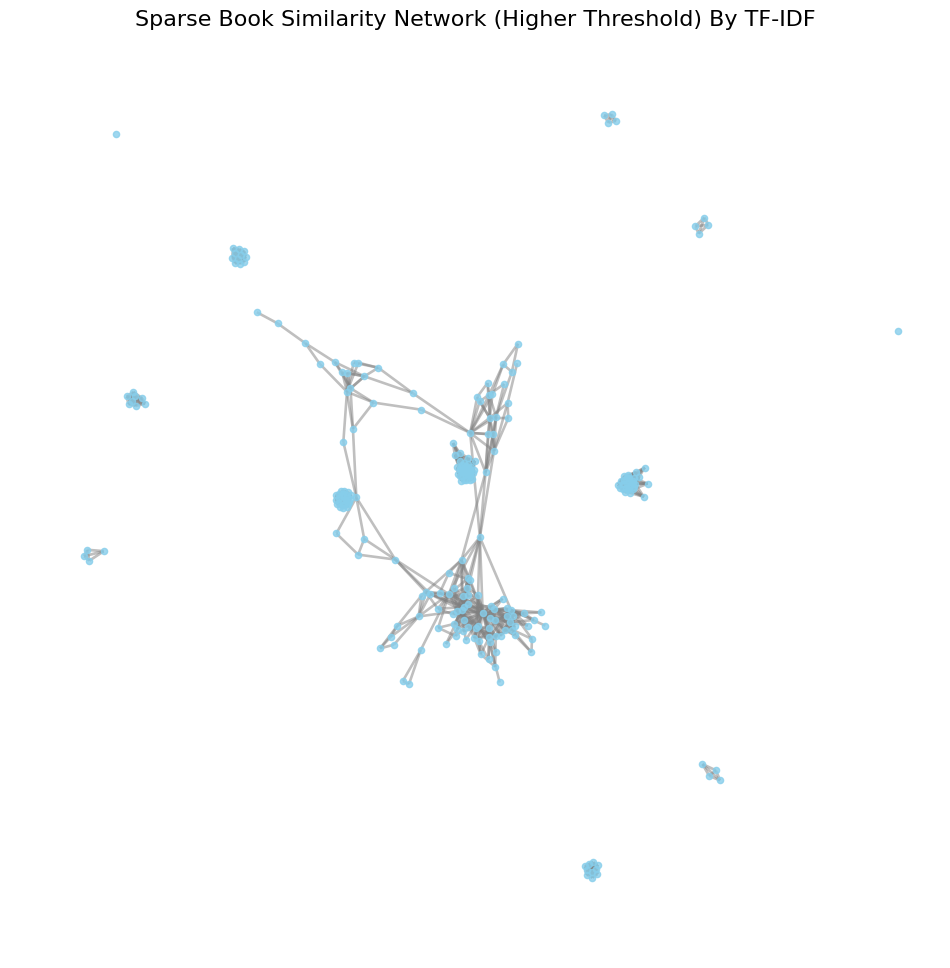

In [21]:
plot_graph(book_cosine_sim_w2v, thresh = 0.94)